In [6]:
from Bio.PDB import *
from Bio import AlignIO
import numpy as np
import matplotlib.pyplot as plt
import Bio.PDB
from Bio.SVDSuperimposer import SVDSuperimposer
from scipy.spatial.distance import cdist
import seaborn as sns
import sys
import warnings
from numba import jit, float64
import time
import math
import pandas as pd
import os

if not sys.warnoptions:
    warnings.simplefilter("ignore")

@jit(nopython=True)
def euclidian_distance(point_1, point_2):
    dist = np.sqrt(np.sum(np.square(point_1 - point_2)))
    return dist


def distance_residues(residue1, residue2, if_Ca=False, if_average_res_pos=False, if_minumum=False):
    
    # make sure only single mode is used
    if (if_Ca and if_average_res_pos) or (if_average_res_pos and if_minumum) or (if_average_res_pos and if_minumum):
        print('Chose only a single mode.')
        raise ValueError('Too many modes selected')
    
    # skip the same residue for n/n
    if residue1['CA'].coord[0] == residue2['CA'].coord[0] and residue1['CA'].coord[1] == residue2['CA'].coord[1] and residue1['CA'].coord[2] == residue2['CA'].coord[2]:
        return 0
    
    if not if_Ca and not if_average_res_pos and not if_minumum:
        all_dist = []
        sum = 0
        n = 0
        for atom1 in residue1:
            for atom2 in residue2:

                # calculate distance per atom pair
                all_dist.append(math.dist(atom1.coord, atom2.coord))

        distance_averaged = np.average(all_dist)

        # use mean distances between atoms instead of distance of mean position?
        return distance_averaged

    elif if_Ca:
        return math.dist(residue1['CA'].coord, residue2['CA'].coord)

    elif if_average_res_pos:
        res1_pos = []
        res2_pos = []
        for atom1 in residue1:
            res1_pos.append(atom1.coord)

        for atom2 in residue2:
            res2_pos.append(atom2.coord)

        res1_pos_avg = np.average(res1_pos)
        res12_pos_avg = np.average(res2_pos)

        return math.dist(res1_pos_avg, res12_pos_avg)
    
    elif if_minumum:
        all_dist = []
        
        for atom1 in residue1:
            for atom2 in residue2:

                # calculate distance per atom pair
                all_dist.append(math.dist(atom1.coord, atom2.coord))


        distance_averaged = np.min(all_dist)

        # use minimum distance between atoms
        return distance_averaged


def calc_contact_map_chains(chain1, chain2, if_Ca=False, matrix_override=160, 
                            martix_shape_override=(1,161,1,161), binary=False, 
                            binary_distance=8, use_non_binary_dist=False, if_average_res_pos=False, if_minumum=False):

    contact_matrix = np.zeros((matrix_override,matrix_override))

    for row in chain1:
        for column in chain2:

            res1 = row.id[1]
            res2 = column.id[1]

            contact_matrix[res1, res2] = distance_residues(row, column, if_Ca=if_Ca, 
                                if_average_res_pos=if_average_res_pos, if_minumum=if_minumum)

    if binary:
        contact_matrix[contact_matrix <= binary_distance] = 1
        contact_matrix[contact_matrix > binary_distance] = 0

    contact_matrix = contact_matrix[martix_shape_override[0]:martix_shape_override[1],
                                    martix_shape_override[2]:martix_shape_override[3]]

    if use_non_binary_dist:
        contact_matrix[contact_matrix > binary_distance] = 'NaN'
    
    return contact_matrix

p = PDBParser()
## Files were realigned in PyMol
structure1 = p.get_structure("invivo", os.path.join('structures', "invivo_aligned.pdb"))[0]
structure2 = p.get_structure("fimd", os.path.join('structures', "fimd_aligned.pdb"))[0]
structure3 = p.get_structure("invitro", os.path.join('structures', "invitro_aligned.pdb"))[0]
#structure4 = p.get_structure("invitro", r"C:\Users\didny\OneDrive\PostDOC\pilus_story\figure\5oh0.pdb")[0]


structures = [structure1, structure2, structure3]

In [7]:
interface_n_n = ['AA', 'BB', 'CC', 'DD', 'EE', 'FF']
interfaces_n_n1 = ['AB', 'BC', 'CD', 'DE', 'EF']
interfaces_n_n2 = ['AC', 'BD', 'CE', 'DF']
interfaces_n_n3 = ['AD', 'BE', 'CF']
interfaces_n_n4 = ['AE', 'BF']

interface_names = ['nn', 'n1', 'n2', 'n3', 'n4']
structures_names = ['invivo', 'FimD', 'invitro']

In [8]:
global_matrix_dict = {}

for n, structure in enumerate(structures):

    chain_matrix_dict = {}
    
    for m, interface in enumerate([interface_n_n, interfaces_n_n1, interfaces_n_n2, interfaces_n_n3, interfaces_n_n4]):
        for chains in interface:
            chain1 = chains[0]
            chain2 = chains[1]

            matrix = calc_contact_map_chains(structure[chain1], structure[chain2], binary=True, binary_distance=8,
                                             martix_shape_override=(2, 161, 2, 161), if_minumum=True, 
                                             if_average_res_pos=False, if_Ca=False)

            chain_matrix_dict['{}{}'.format(chain1, chain2)] = matrix

    global_matrix_dict['{}'.format(structures_names[n])] = chain_matrix_dict
    print(global_matrix_dict.keys())

dict_keys(['invivo'])
dict_keys(['invivo', 'FimD'])
dict_keys(['invivo', 'FimD', 'invitro'])


In [9]:
invivo_all_interfaces = global_matrix_dict['invivo']
infimd_all_interfaces = global_matrix_dict['FimD']
invitro_all_interfaces = global_matrix_dict['invitro']

print(invivo_all_interfaces.keys())

dict_keys(['AA', 'BB', 'CC', 'DD', 'EE', 'FF', 'AB', 'BC', 'CD', 'DE', 'EF', 'AC', 'BD', 'CE', 'DF', 'AD', 'BE', 'CF', 'AE', 'BF'])


In [10]:
invivo_all_interfaces = global_matrix_dict['invivo']
fimd_all_interfaces = global_matrix_dict['FimD']
invitro_all_interfaces = global_matrix_dict['invitro']

invivo_nn = []
invivo_n1 = []
invivo_n2 = []
invivo_n3 = []
invivo_n4 = []

fimd_nn = []
fimd_n1 = []
fimd_n2 = []
fimd_n3 = []
fimd_n4 = []

invitro_nn = []
invitro_n1 = []
invitro_n2 = []
invitro_n3 = []
invitro_n4 = []

for interface in invivo_all_interfaces:
    if interface in interface_n_n:
        invivo_nn.append(invivo_all_interfaces[interface])
    elif interface in interfaces_n_n1:
        invivo_n1.append(invivo_all_interfaces[interface])
    elif interface in interfaces_n_n2:
        invivo_n2.append(invivo_all_interfaces[interface])
    elif interface in interfaces_n_n3:
        invivo_n3.append(invivo_all_interfaces[interface])
    elif interface in interfaces_n_n4:
        invivo_n4.append(invivo_all_interfaces[interface])
        
for interface in fimd_all_interfaces:
    if interface in interface_n_n:
        fimd_nn.append(fimd_all_interfaces[interface])
    elif interface in interfaces_n_n1:
        fimd_n1.append(fimd_all_interfaces[interface])
    elif interface in interfaces_n_n2:
        fimd_n2.append(fimd_all_interfaces[interface])
    elif interface in interfaces_n_n3:
        fimd_n3.append(fimd_all_interfaces[interface])
    elif interface in interfaces_n_n4:
        fimd_n4.append(fimd_all_interfaces[interface])

for interface in invitro_all_interfaces:
    if interface in interface_n_n:
        invitro_nn.append(invitro_all_interfaces[interface])
    elif interface in interfaces_n_n1:
        invitro_n1.append(invitro_all_interfaces[interface])
    elif interface in interfaces_n_n2:
        invitro_n2.append(invitro_all_interfaces[interface])
    elif interface in interfaces_n_n3:
        invitro_n3.append(invitro_all_interfaces[interface])
    elif interface in interfaces_n_n4:
        invitro_n4.append(invitro_all_interfaces[interface])

In [11]:
data_interface_nn = [[invivo_nn, fimd_nn], [invivo_nn, invitro_nn], [fimd_nn, invitro_nn]]
data_interface_n1 = [[invivo_n1, fimd_n1], [invivo_n1, invitro_n1], [fimd_n1, invitro_n1]]
data_interface_n2 = [[invivo_n2, fimd_n2], [invivo_n2, invitro_n2], [fimd_n2, invitro_n2]]
data_interface_n3 = [[invivo_n3, fimd_n3], [invivo_n3, invitro_n3], [fimd_n3, invitro_n3]]
data_interface_n4 = [[invivo_n4, fimd_n4], [invivo_n4, invitro_n4], [fimd_n4, invitro_n4]]

invivo = [invivo_nn, invivo_n1, invivo_n2, invivo_n3, invivo_n4]
invitro = [invitro_nn, invivo_n1, invivo_n2, invivo_n3, invivo_n4]
fimd = [fimd_nn, fimd_n1, fimd_n2, fimd_n3, fimd_n4]

single_structures = [invivo, invitro, fimd]

interface_poll = [data_interface_nn, data_interface_n1, data_interface_n2, data_interface_n3, data_interface_n4]

pool_names = ['nn','n1','n2','n3','n4']
interface_between = ['invivo, fimd', 'invivo, invitro', 'fimd, invitro']

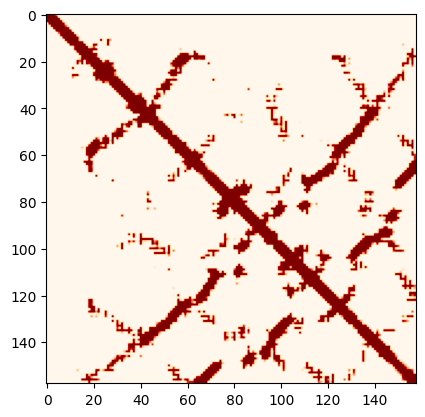

nn invivo, fimd 
 110.0 1496.6666666666667


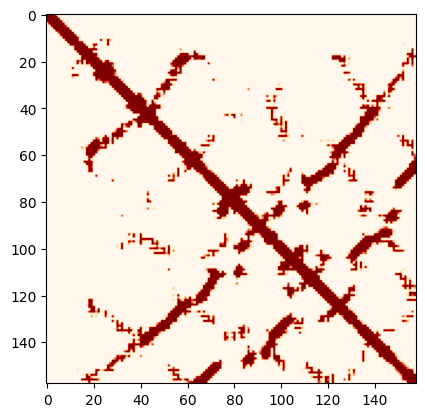

nn invivo, invitro 
 115.0 1502.1666666666667


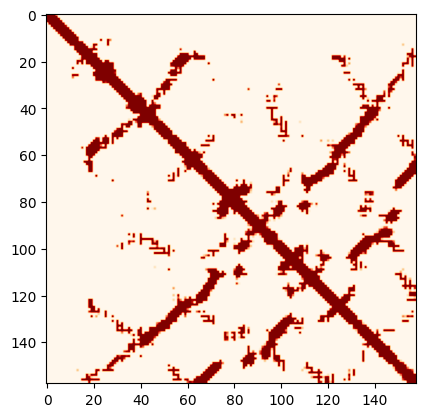

nn fimd, invitro 
 70.66666666666667 1519.0


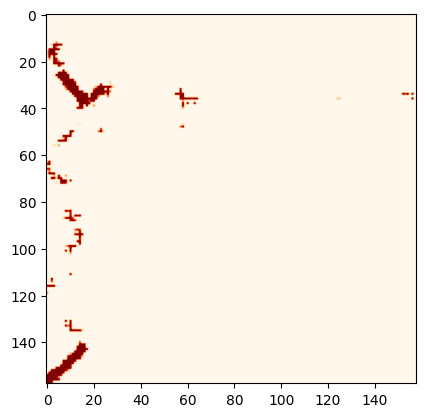

n1 invivo, fimd 
 44.4 395.0


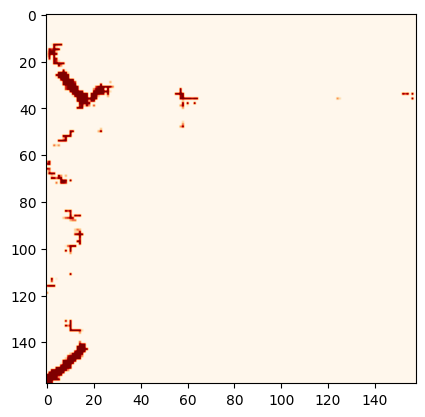

n1 invivo, invitro 
 51.4 397.6


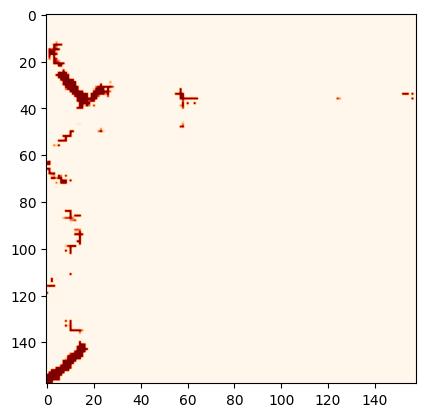

n1 fimd, invitro 
 38.2 404.6


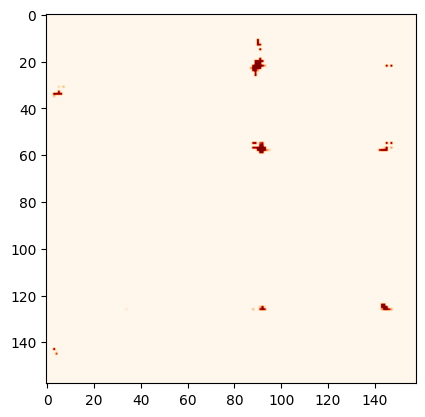

n2 invivo, fimd 
 14.0 83.75


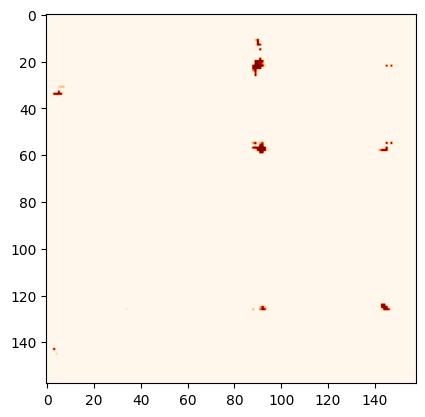

n2 invivo, invitro 
 12.5 79.0


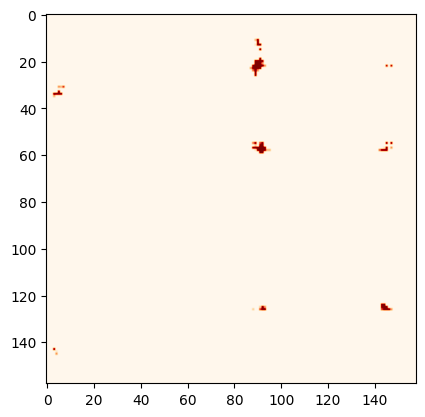

n2 fimd, invitro 
 17.5 87.0


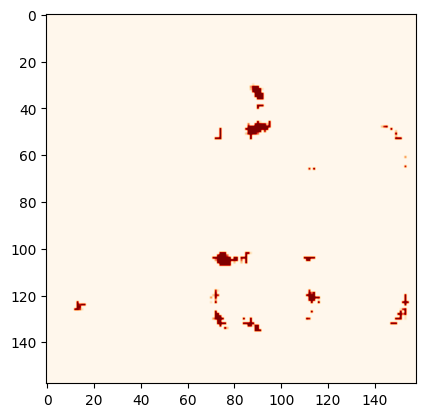

n3 invivo, fimd 
 22.333333333333332 249.66666666666666


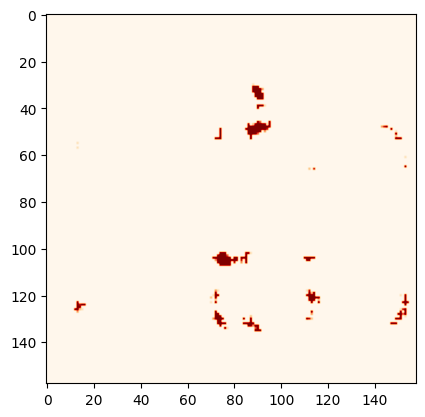

n3 invivo, invitro 
 26.0 252.0


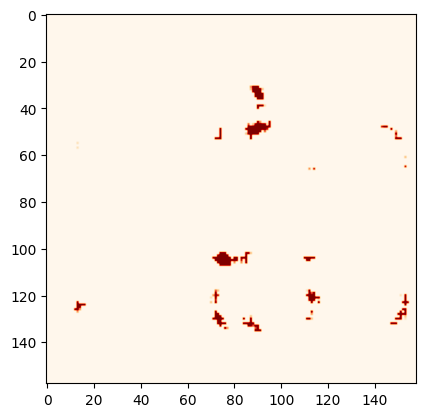

n3 fimd, invitro 
 25.666666666666668 258.0


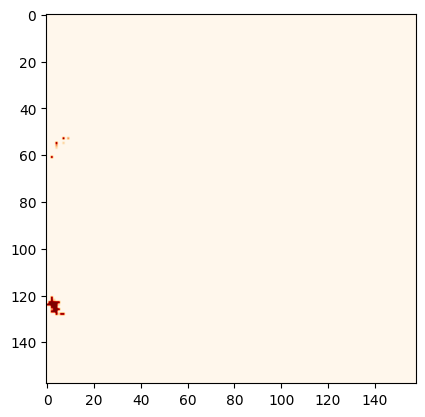

n4 invivo, fimd 
 4.5 32.0


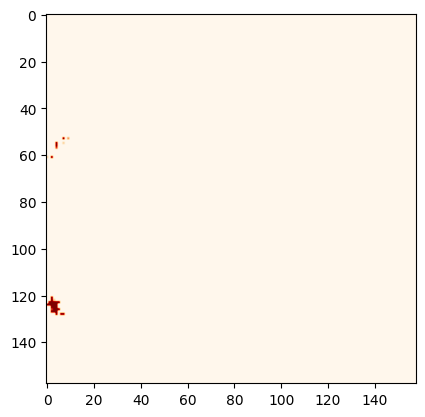

n4 invivo, invitro 
 3.5 32.5


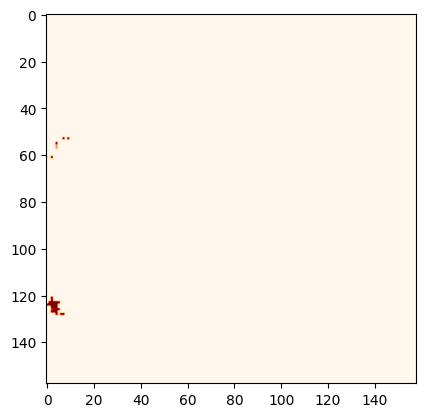

n4 fimd, invitro 
 4.0 32.5


In [12]:
with open('pili_interfaces.txt', 'w') as fh:

    for n, pool in enumerate(interface_poll):
        for m, interface in enumerate(pool):
            inter1 = interface[0]
            inter2 = interface[1]    

            interface_diff = np.array(inter1)+np.array(inter2)
            diff = np.sum(interface_diff, axis=0)

            plt.imshow(diff, cmap='OrRd')
            plt.show()
            counts = np.unique(interface_diff, return_counts=True)

            if n == 0:
                # divide by 2 (matrix is symmetrical along center)
                different_interfaces = (np.sum(counts[1][1:-1]) / 2) / interface_diff.shape[0]
                all_interfaces = (np.sum(counts[1][1:]) / 2) / interface_diff.shape[0] - diff.shape[0]

            else:
                different_interfaces = np.sum(counts[1][1:-1]) / interface_diff.shape[0]
                all_interfaces = np.sum(counts[1][1:]) / interface_diff.shape[0]

            print(pool_names[n],interface_between[m], '\n',different_interfaces, all_interfaces)
            print(pool_names[n],interface_between[m], different_interfaces, all_interfaces, file=fh)


(6, 158, 158)


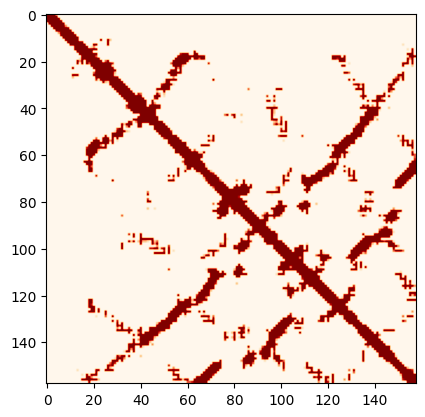

invivo nn 
 188.0 1497.0
(5, 158, 158)


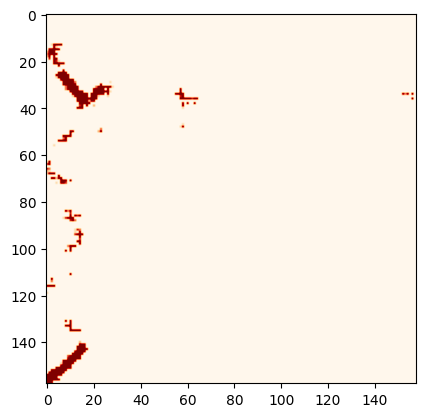

invivo n1 
 61 391
(4, 158, 158)


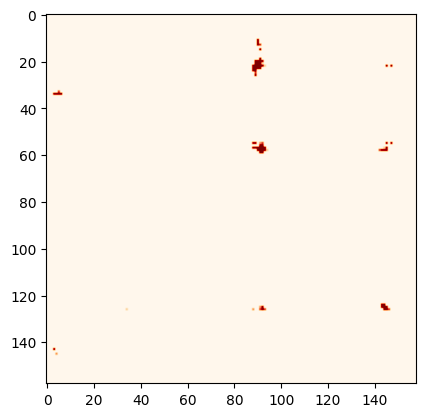

invivo n2 
 17 79
(3, 158, 158)


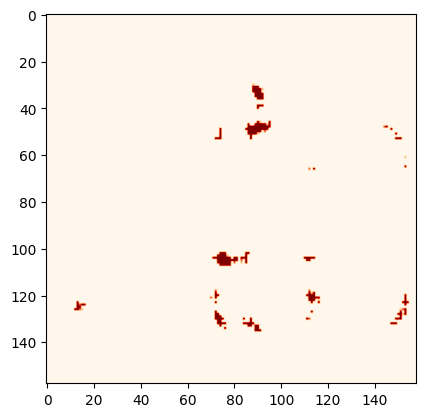

invivo n3 
 25 245
(2, 158, 158)


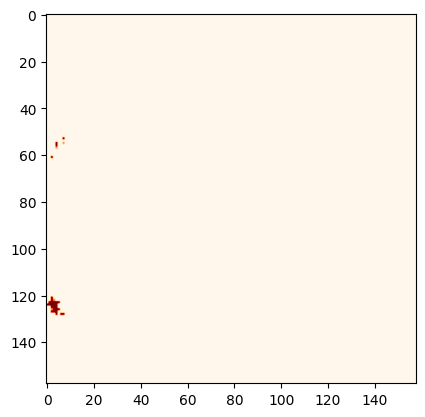

invivo n4 
 4 32
(6, 158, 158)


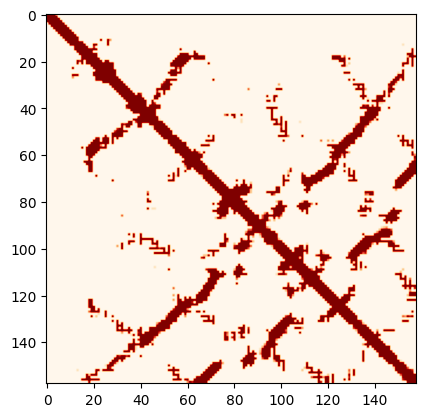

invitro nn 
 123.0 1546.0
(5, 158, 158)


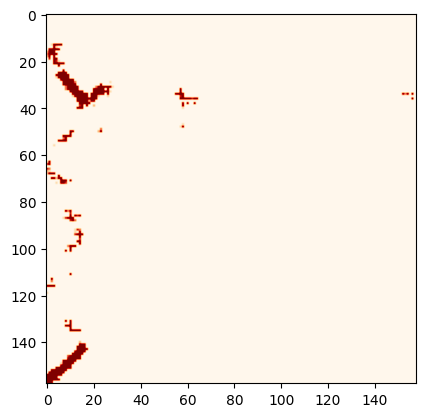

invitro n1 
 61 391
(4, 158, 158)


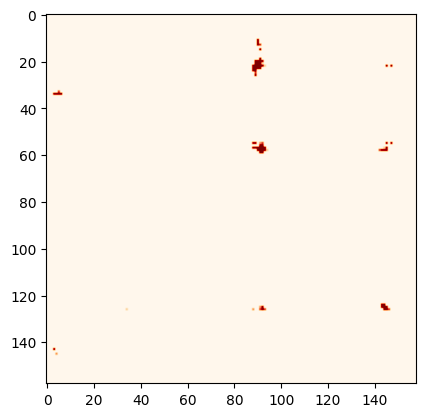

invitro n2 
 17 79
(3, 158, 158)


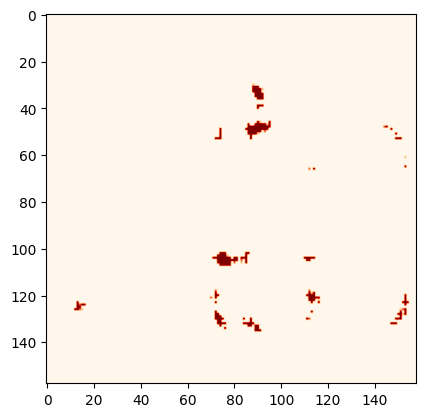

invitro n3 
 25 245
(2, 158, 158)


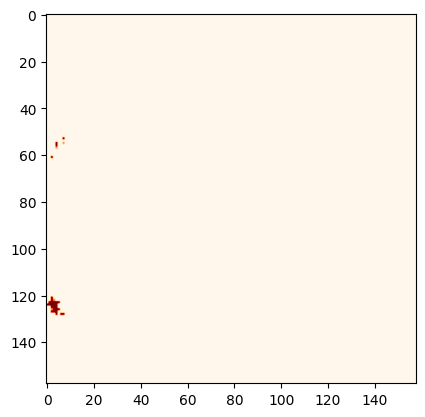

invitro n4 
 4 32
(6, 158, 158)


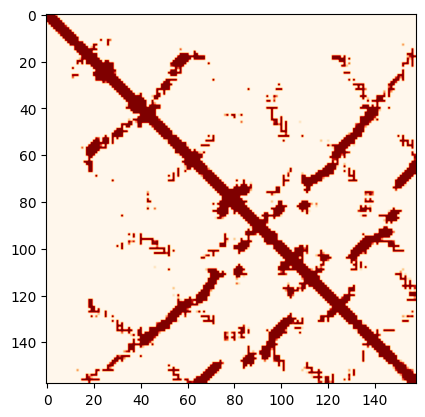

fimd nn 
 127.0 1543.0
(5, 158, 158)


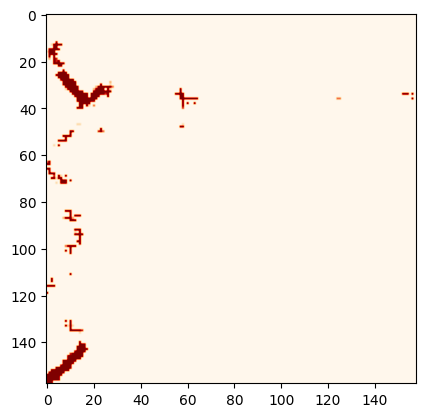

fimd n1 
 38 408
(4, 158, 158)


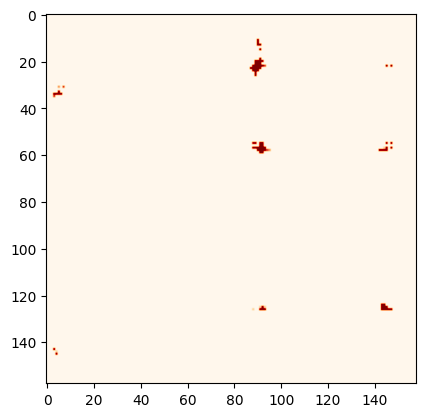

fimd n2 
 11 88
(3, 158, 158)


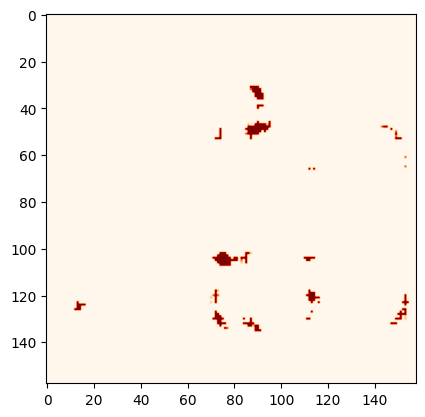

fimd n3 
 21 255
(2, 158, 158)


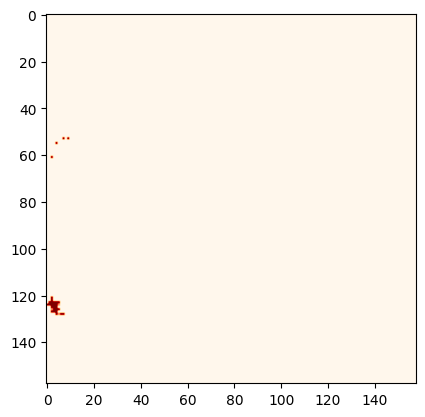

fimd n4 
 3 31


In [186]:
structures_names = ['invivo', 'invitro', 'fimd']

with open('per_pilus_interfaces.txt', 'w') as fh:

    for n, pool in enumerate(single_structures):
        for m, interface in enumerate(pool):
            interface = np.array(interface)
            print(interface.shape)

            interface_diff = np.sum(interface, axis=0)

            plt.imshow(interface_diff, cmap='OrRd')
            plt.savefig('{}{}.svg'.format(structures_names[n], interface_names[m]))
            plt.show()
            
            counts = np.unique(interface_diff, return_counts=True)

            # divide by 2 (matrix is symmetrical along center)
            if m == 0:
                different_interfaces = np.sum(counts[1][1:-1]) / 2
                
                #subtract n->n interfaces (e.g. A12->A12)
                all_interfaces = np.sum(counts[1][1:]) / 2 - interface_diff.shape[0]
            else:
                different_interfaces = np.sum(counts[1][1:-1])
                all_interfaces = np.sum(counts[1][1:])

            print(structures_names[n],interface_names[m], '\n',different_interfaces, all_interfaces)
            print(structures_names[n],interface_names[m], different_interfaces, all_interfaces, file=fh)


   diff nn  diff n1  diff n2  diff n3  diff n4
0    188.0       61       17       25        4
1    123.0       61       17       25        4
2    127.0       38       11       21        3


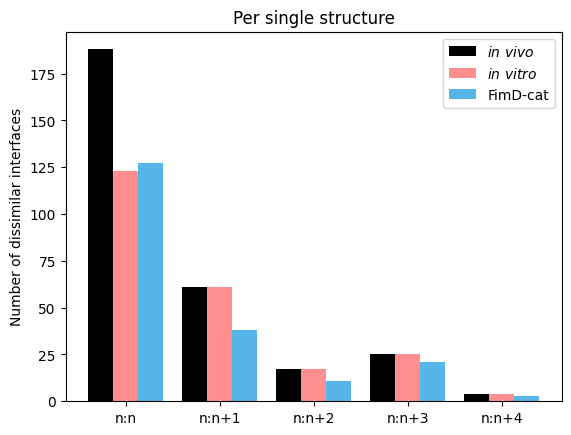

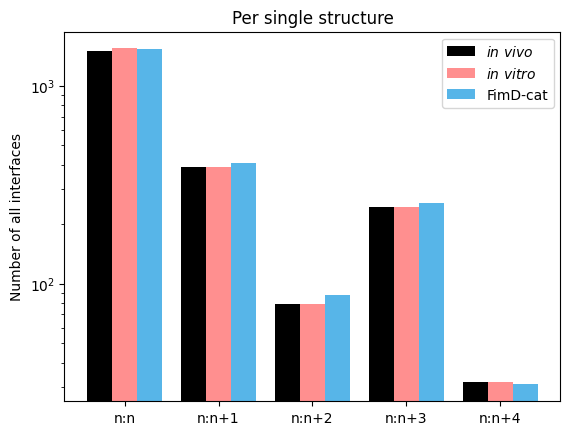

In [13]:
from Bio.PDB import *
from Bio import AlignIO
import numpy as np
import matplotlib.pyplot as plt
import Bio.PDB
from Bio.SVDSuperimposer import SVDSuperimposer
from scipy.spatial.distance import cdist
import seaborn as sns
import sys
import warnings
from numba import jit, float64
import time
import math
import pandas as pd

data_interfaces = pd.read_csv('pili_interfaces.csv', delimiter='\t')
data_different_interfaces = data_interfaces[['diff nn', 'diff n1', 'diff n2', 'diff n3', 'diff n4']]
data_all_interfaces = data_interfaces[['all nn', 'all n1', 'all n2', 'all n3', 'all n4']]

x_names = ['n:n', 'n:n+1', 'n:n+2', 'n:n+3', 'n:n+4']
width = 0.4
print(data_different_interfaces)

x = np.arange(len(x_names))*1.5

plt.bar(x - width, data_different_interfaces.iloc[0], width, label='$\it{in\ vivo}$', color='k')
plt.bar(x, data_different_interfaces.iloc[1], width, label='$\it{in\ vitro}$', color='#FF8F8F')
plt.bar(x + width, data_different_interfaces.iloc[2], width, label='FimD-cat', color='#57B5E8')

plt.ylabel('Number of dissimilar interfaces')
plt.title('Per single structure')
plt.xticks(x, x_names)
plt.legend()
plt.savefig('per_structure_diss.svg')
plt.show()

''''''

plt.bar(x - width, data_all_interfaces.iloc[0], width, label='$\it{in\ vivo}$', color='k')
plt.bar(x, data_all_interfaces.iloc[1], width, label='$\it{in\ vitro}$', color='#FF8F8F')
plt.bar(x + width, data_all_interfaces.iloc[2], width, label='FimD-cat', color='#57B5E8')

plt.ylabel('Number of all interfaces')
plt.title('Per single structure')
plt.yscale('log')
plt.xticks(x, x_names)
plt.legend()
plt.savefig('per_structure_all.svg')
plt.show()

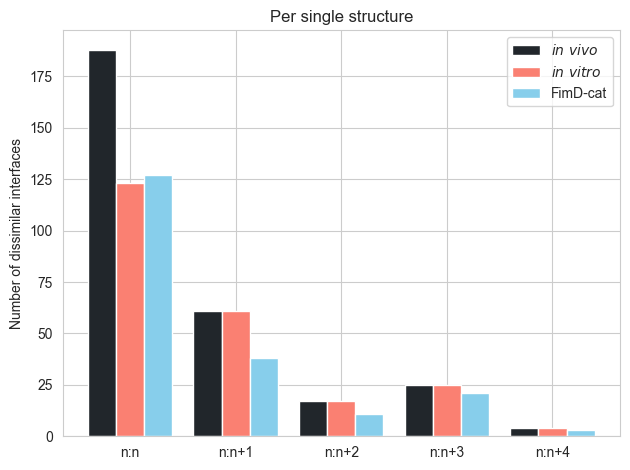

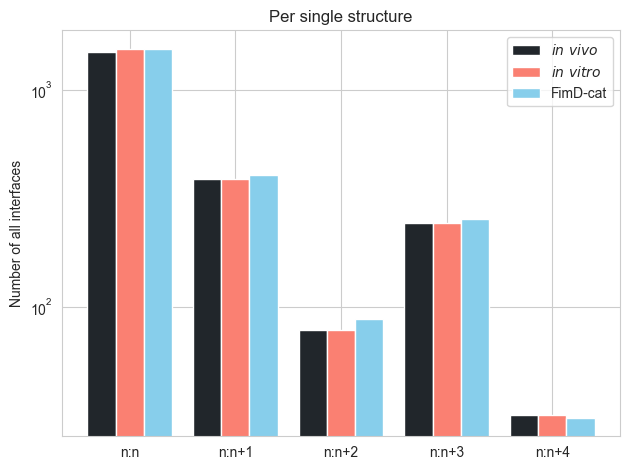

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

data_interfaces = pd.read_csv('pili_interfaces.csv', delimiter='\t')
data_different_interfaces = data_interfaces[['diff nn', 'diff n1', 'diff n2', 'diff n3', 'diff n4']]
data_all_interfaces = data_interfaces[['all nn', 'all n1', 'all n2', 'all n3', 'all n4']]

x_names = ['n:n', 'n:n+1', 'n:n+2', 'n:n+3', 'n:n+4']
width = 0.4

x = np.arange(len(x_names))*1.5

sns.set_style("whitegrid")  # set seaborn style
colors = ['#21262b', '#FA8072','#87CEEB' ]  # select a color palette

plt.bar(x - width, data_different_interfaces.iloc[0], width, label='$\it{in\ vivo}$', color=colors[0])
plt.bar(x, data_different_interfaces.iloc[1], width, label='$\it{in\ vitro}$', color=colors[1])
plt.bar(x + width, data_different_interfaces.iloc[2], width, label='FimD-cat', color=colors[2])

plt.ylabel('Number of dissimilar interfaces')
plt.title('Per single structure')
plt.xticks(x, x_names)
plt.legend()
plt.tight_layout()  # to ensure labels aren't cut off
plt.savefig('per_structure_diss.svg')
plt.show()

plt.bar(x - width, data_all_interfaces.iloc[0], width, label='$\it{in\ vivo}$', color=colors[0])
plt.bar(x, data_all_interfaces.iloc[1], width, label='$\it{in\ vitro}$', color=colors[1])
plt.bar(x + width, data_all_interfaces.iloc[2], width, label='FimD-cat', color=colors[2])

plt.ylabel('Number of all interfaces')
plt.title('Per single structure')
plt.yscale('log')
plt.xticks(x, x_names)
plt.legend()
plt.tight_layout()  # to ensure labels aren't cut off
plt.grid('off')
plt.savefig('per_structure_all.svg')
plt.show()


      diff nn  diff n1  diff n2    diff n3  diff n4
0  110.000000     44.4     14.0  22.333333      4.5
1  115.000000     51.4     12.5  26.000000      3.5
2   70.666667     38.2     17.5  25.666667      4.0


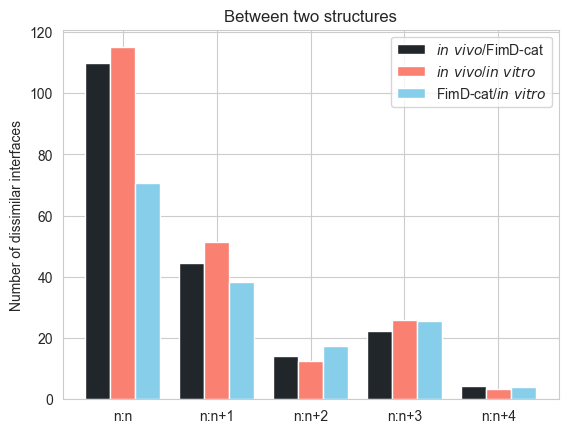

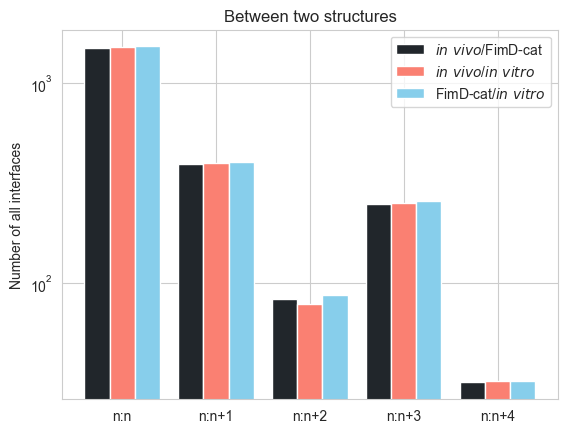

In [17]:
data_interfaces = pd.read_csv('pili_comp_interfaces.csv', delimiter='\t')
data_different_interfaces = data_interfaces[['diff nn', 'diff n1', 'diff n2', 'diff n3', 'diff n4']]
data_all_interfaces = data_interfaces[['all nn', 'all n1', 'all n2', 'all n3', 'all n4']]

x_names = ['n:n', 'n:n+1', 'n:n+2', 'n:n+3', 'n:n+4']
width = 0.4
print(data_different_interfaces)

x = np.arange(len(x_names))*1.5

c1='#1e948b'
c2='#82a1a5'
c3='#e7adbf'
c1, c2, c3 = ['#21262b', '#FA8072','#87CEEB' ]

plt.bar(x - width, data_different_interfaces.iloc[0], width, label='$\it{in\ vivo}$/FimD-cat', color=c1)
plt.bar(x, data_different_interfaces.iloc[1], width, label='$\it{in\ vivo}$/$\it{in\ vitro}$', color=c2)
plt.bar(x + width, data_different_interfaces.iloc[2], width, label='FimD-cat/$\it{in\ vitro}$', color=c3)

plt.ylabel('Number of dissimilar interfaces')
plt.title('Between two structures')
plt.xticks(x, x_names)
plt.legend()
plt.savefig('between_structures_diss.svg')
plt.show()

''''''

plt.bar(x - width, data_all_interfaces.iloc[0], width, label='$\it{in\ vivo}$/FimD-cat', color=c1)
plt.bar(x, data_all_interfaces.iloc[1], width, label='$\it{in\ vivo}$/$\it{in\ vitro}$', color=c2)
plt.bar(x + width, data_all_interfaces.iloc[2], width, label='FimD-cat/$\it{in\ vitro}$', color=c3)

plt.ylabel('Number of all interfaces')
plt.title('Between two structures')
plt.yscale('log')
plt.xticks(x, x_names)
plt.legend()
plt.savefig('between_structures_all.svg')
plt.show()